In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def preprocessing_op(image_op, config):
    """
    Creates preprocessing operations that are going to be applied on a single frame.
    
    TODO: Customize for your needs.
    You can do any preprocessing (masking, normalization/scaling of inputs, augmentation, etc.) by using tensorflow operations.
    Built-in image operations: https://www.tensorflow.org/api_docs/python/tf/image 
    """
    with tf.name_scope("preprocessing"):
        # Reshape serialized image.
        image_op = tf.reshape(image_op, (config['img_height'], 
                                         config['img_width'], 
                                         config['img_num_channels'])
                          )
        # Convert from RGB to grayscale.
        image_op = tf.image.rgb_to_grayscale(image_op)
        
        # Integer to float.
        image_op = tf.to_float(image_op)
        # Crop
        image_op = tf.image.resize_image_with_crop_or_pad(image_op, 60, 60)
        
        # Resize operation requires 4D tensors (i.e., batch of images).
        # Reshape the image so that it looks like a batch of one sample: [1,60,60,1]
        image_op = tf.expand_dims(image_op, 0)
        # Resize
        image_op = tf.image.resize_bilinear(image_op, np.asarray([32,32]))
        # Reshape the image: [32,32,1]
        image_op = tf.squeeze(image_op, 0)
        
        # Normalize (zero-mean unit-variance) the image locally, i.e., by using statistics of the 
        # image not the whole data or sequence. 
        image_op = tf.image.per_image_standardization(image_op)
        
        # Flatten image
        image_op = tf.reshape(image_op, [-1])
    
        return image_op

def read_and_decode_sequence(filename_queue, config):
    # Create a TFRecordReader.
    readerOptions = tf.python_io.TFRecordOptions(compression_type=tf.python_io.TFRecordCompressionType.GZIP)
    reader = tf.TFRecordReader(options=readerOptions)
    _, serialized_example = reader.read(filename_queue)
    
    # Read one sequence sample.
    # The training and validation files contains the following fields:
    # - label: label of the sequence which take values between 1 and 20.
    # - length: length of the sequence, i.e., number of frames.
    # - depth: sequence of depth images. [length x height x width x numChannels]
    # - rgb: sequence of rgb images. [length x height x width x numChannels]
    # - segmentation: sequence of segmentation maskes. [length x height x width x numChannels]
    # - skeleton: sequence of flattened skeleton joint positions. [length x numJoints]
    #
    # The test files doesn't contain "label" field.
    # [height, width, numChannels] = [80, 80, 3]
    with tf.name_scope("TFRecordDecoding"):
        context_encoded, sequence_encoded = tf.parse_single_sequence_example(
                serialized_example,
                # "label" and "lenght" are encoded as context features. 
                context_features={
                    "label": tf.FixedLenFeature([], dtype=tf.int64),
                    "length": tf.FixedLenFeature([], dtype=tf.int64)
                },
                # "depth", "rgb", "segmentation", "skeleton" are encoded as sequence features.
                sequence_features={
                    "depth": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "rgb": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "segmentation": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "skeleton": tf.FixedLenSequenceFeature([], dtype=tf.string),
                })

        # Fetch required data fields. 
        # TODO: Customize for your design. Assume that only the RGB images are used for now.
        # Decode the serialized RGB images.    
        seq_rgb = tf.decode_raw(sequence_encoded['rgb'], tf.uint8)
        seq_label = context_encoded['label']
        # Tensorflow requires the labels start from 0. Before you create submission csv, 
        # increment the predictions by 1.
        seq_label = seq_label - 1
        seq_len = tf.to_int32(context_encoded['length'])
        # Output dimnesionality: [seq_len, height, width, numChannels]
        # tf.map_fn applies the preprocessing function on every image in the sequence, i.e., frame.
        seq_rgb = tf.map_fn(lambda x: preprocessing_op(x, config),
                                elems=seq_rgb,
                                dtype=tf.float32,
                                back_prop=False)
    
        return [seq_rgb, seq_label, seq_len]
    

def input_pipeline(filenames, config):
    with tf.name_scope("input_pipeline"):
        # Create a queue of TFRecord input files.
        filename_queue = tf.train.string_input_producer(filenames, num_epochs=config['num_epochs'], shuffle=True)
        # Read the data from TFRecord files, decode and create a list of data samples by using threads.
        sample_list = [read_and_decode_sequence(filename_queue, config) for _ in range(config['ip_num_read_threads'])]
        # Create batches.
        # Since the data consists of variable-length sequences, allow padding by setting dynamic_pad parameter.
        # "batch_join" creates batches of samples and pads the sequences w.r.t the max-length sequence in the batch.
        # Hence, the padded sequence length can be different for different batches.
        batch_rgb, batch_labels, batch_lens = tf.train.batch_join(sample_list,
                                                    batch_size=config['batch_size'],
                                                    capacity=config['ip_queue_capacity'],
                                                    enqueue_many=False,
                                                    dynamic_pad=True,
                                                    name="batch_join_and_pad")

        return batch_rgb, batch_labels, batch_lens

In [3]:
config = {}
config['checkpoint_every_step'] = 1000
config['print_every_step'] = 100
config['log_dir'] = './runs/'

config['img_height'] = 80
config['img_width'] = 80
config['img_num_channels'] = 3

config['num_epochs'] = 100
config['batch_size'] = 32
config['learning_rate'] = 1e-3

config['num_rnn_hidden_units'] = 512
config['num_rnn_layers'] = 2
config['num_class_labels'] = 20

config['ip_queue_capacity'] = config['batch_size']*50
config['ip_num_read_threads'] = 10

config['data_dir'] = "/home/eaksan/uie_data/train/"
config['file_format'] = "dataTrain_%d.tfrecords"
config['file_ids'] = list(range(1,41))

# Create a unique output directory for this experiment.
timestamp = str(int(time.time()))
config['model_dir'] = os.path.abspath(os.path.join(config['log_dir'], timestamp))
print("Writing to {}\n".format(config['model_dir']))

Writing to /media/eaksan/Warehouse-SSD/Workspace/uie_ss17/assignment3/public/runs/1494252247



In [4]:
class SequenceClassifier():
    def __init__(self, config, input_op, target_op, seq_len_op):
        """Basic setup.
        Args:
          config: Object containing configuration parameters.
        """
        self.config = config
        self.inputs = input_op
        self.targets = target_op
        self.seq_lengths = seq_len_op
        
    def build_rnn_model(self):
        with tf.variable_scope('rnn_cell'):
            rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units=self.config['num_rnn_hidden_units'])
        with tf.variable_scope('rnn_stack'):
            if self.config['num_rnn_layers'] > 1:
                rnn_cell = tf.contrib.rnn.MultiRNNCell([rnn_cell for _ in range(self.config['num_rnn_layers'])])
            self.model_rnn, self.rnn_state = tf.nn.dynamic_rnn(
                                            cell=rnn_cell,
                                            inputs=self.inputs,
                                            dtype = tf.float32,
                                            sequence_length=self.seq_lengths)
            # Fetch output of the last step.
            self.rnn_last_step = tf.gather_nd(self.model_rnn, tf.stack([tf.range(self.config['batch_size']), self.seq_lengths-1], axis=1))
    
    def build_model(self):
        self.build_rnn_model()
        # Calculate logits
        with tf.variable_scope('logits'):
            self.logits = tf.layers.dense(inputs=self.rnn_last_step, units=self.config['num_class_labels'],
                                            kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                            bias_initializer=tf.contrib.layers.xavier_initializer())
            
    def loss(self):
        # Loss calculations: cross-entropy
        with tf.name_scope("cross_entropy_loss"):
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.targets))
        
    def build_graph(self):
        self.build_model()
        self.loss()
        
        return self.logits, self.loss

In [5]:
# Create a list of tfRecord input files.
filenames = [os.path.join(config['data_dir'], config['file_format'] % i) for i in config['file_ids']]
# Create data loading operators. This will be represented as a node in the computational graph.
batch_samples_op, batch_labels_op, batch_seq_len_op = input_pipeline(filenames, config)

# Create placeholders for training and monitoring variables.
#mode_op = tf.placeholder(tf.bool, name="mode")
loss_avg = tf.placeholder(tf.float32, name="loss_avg")
accuracy_avg = tf.placeholder(tf.float32, name="accuracy_avg")

# Create model
seqClassifierModel = SequenceClassifier(config, batch_samples_op, batch_labels_op, batch_seq_len_op)
logits, loss = seqClassifierModel.build_graph()

# Accuracy calculations.
with tf.name_scope("accuracy"):
    # Return list of predictions (useful for making a submission)
    predictions = tf.argmax(logits, 1, name="predictions")
    # Return a bool tensor with shape [batch_size] that is true for the
    # correct predictions.
    #correct_predictions = tf.nn.in_top_k(logits, batch_labels_op, 1)
    correct_predictions = tf.equal(tf.argmax(logits, 1), batch_labels_op)
    # Calculate the accuracy per minibatch.
    batch_accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    # Number of correct predictions in order to calculate average accuracy afterwards.
    num_correct_predictions = tf.reduce_sum(tf.cast(correct_predictions, tf.int32))
    
# Create summary ops for monitoring the training.
# Each summary op annotates a node in the computational graph and collects
# data data from it.
summary_trian_loss = tf.summary.scalar('loss', loss)
summary_train_acc = tf.summary.scalar('accuracy_training', batch_accuracy)
summary_avg_accuracy = tf.summary.scalar('accuracy_avg', accuracy_avg)
summary_avg_loss = tf.summary.scalar('loss_avg', loss_avg)

# Group summaries.
summaries_training = tf.summary.merge([summary_trian_loss, summary_train_acc])
summaries_evaluation = tf.summary.merge([summary_avg_accuracy, summary_avg_loss])

# Generate a variable to contain a counter for the global training step.
# Note that it is useful if you save/restore your network.
global_step = tf.Variable(1, name='global_step', trainable=False)

# Create optimization op.
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(config['learning_rate'])
    train_op = optimizer.minimize(loss, global_step=global_step)
    
#Create session object
sess = tf.Session()
# Add the ops to initialize variables.
init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
# Actually intialize the variables
sess.run(init_op)

# Register summary ops.
train_summary_dir = os.path.join(config['model_dir'], "summary", "train")
train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

# Create a saver for writing training checkpoints.
saver = tf.train.Saver(max_to_keep=3)

# Define counters in order to accumulate measurements.
counter_correct_predictions_training = 0.0
counter_loss_training = 0.0

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

In [ ]:
# Run training
try:
    while not coord.should_stop():
        step = tf.train.global_step(sess, global_step)

        if (step%config['checkpoint_every_step']) == 0:
            ckpt_save_path = saver.save(sess, os.path.join(config['model_dir'], 'model'), global_step)
            print("Model saved in file: %s" % ckpt_save_path)

        # This dictionary maps the batch data (as a numpy array) to the
        # placeholder variables in the graph.
        feed_dict = {}

        # Run the optimizer to update weights.
        # Note that "train_op" is responsible from updating network weights.
        # Only the operations that are fed are evaluated.
        # Run the optimizer to update weights.
        train_summary, correct_predictions_training, loss_training, _ = sess.run([summaries_training, num_correct_predictions, loss, train_op], feed_dict=feed_dict)
        # Update counters.
        counter_correct_predictions_training += correct_predictions_training
        counter_loss_training += loss_training
        # Write summary data.
        train_summary_writer.add_summary(train_summary, step)
        
        # Occasionally print status messages.
        if (step%config['print_every_step']) == 0:
            # Calculate average training accuracy.
            accuracy_avg_value_training = counter_correct_predictions_training/(config['print_every_step']*config['batch_size'])
            loss_avg_value_training = counter_loss_training/(config['print_every_step'])
            # [Iteration]
            print("[%d] [Training] Accuracy: %.3f, Loss: %.3f" % (step, accuracy_avg_value_training, loss_avg_value_training))
            counter_correct_predictions_training = 0.0
            counter_loss_training = 0.0
            # Report
            # Note that accuracy_avg and loss_avg placeholders are defined
            # just to feed average results to summaries.
            summary_report = sess.run(summaries_evaluation, feed_dict={accuracy_avg:accuracy_avg_value_training, loss_avg:loss_avg_value_training})
            train_summary_writer.add_summary(summary_report, step)
        
except tf.errors.OutOfRangeError:
    print('Done training for %d epochs, %d steps.' % (config['num_epochs'], step))
finally:
    # When done, ask the threads to stop.
    coord.request_stop()

# Wait for threads to finish.
coord.join(threads)

ckpt_save_path = saver.save(sess, os.path.join(config['model_dir'], 'model'), global_step)
print("Model saved in file: %s" % ckpt_save_path)
sess.close()

[100] [Training] Accuracy: 0.045, Loss: 3.088
[200] [Training] Accuracy: 0.052, Loss: 3.015
[300] [Training] Accuracy: 0.049, Loss: 3.005
[400] [Training] Accuracy: 0.057, Loss: 2.999
[500] [Training] Accuracy: 0.061, Loss: 2.994
[600] [Training] Accuracy: 0.056, Loss: 2.993
[700] [Training] Accuracy: 0.059, Loss: 2.993
[800] [Training] Accuracy: 0.062, Loss: 2.991
[900] [Training] Accuracy: 0.060, Loss: 2.990
Model saved in file: /media/eaksan/Warehouse-SSD/Workspace/uie_ss17/assignment3/public/runs/1494252247/model-1000
[1000] [Training] Accuracy: 0.069, Loss: 2.984
[1100] [Training] Accuracy: 0.064, Loss: 2.979
[1200] [Training] Accuracy: 0.067, Loss: 2.978
[1300] [Training] Accuracy: 0.074, Loss: 2.969
[1400] [Training] Accuracy: 0.072, Loss: 2.974
[1500] [Training] Accuracy: 0.081, Loss: 2.960
[1600] [Training] Accuracy: 0.077, Loss: 2.966
[1700] [Training] Accuracy: 0.077, Loss: 2.950


# Samples: 16
Sequence lengths: [62 88 62 63 82 98 73 63 57 71 76 59 73 63 61 52]
Sequence labels: [12 11 17 16 18 13  4 13 19  8 14  2 18 14  1 10]
Sequence type: <class 'numpy.ndarray'>
Sequence shape: (16, 98, 1024)
(flattened) Image shape: (1024,)
Image shape: (32, 32)


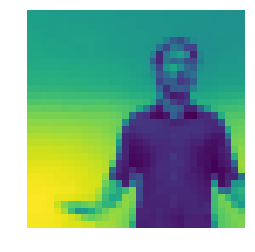

In [3]:
'''
A simple sanity check for input pipeline:
'''
def test_input_loader():
    config = {}
    config['img_height'] = 80
    config['img_width'] = 80
    config['img_num_channels'] = 3
    config['num_epochs'] = 10
    config['batch_size'] = 16
    # Capacity of the queue which contains the samples read by data readers.
    # Make sure that it has enough capacity.
    config['ip_queue_capacity'] = config['batch_size']*10  
    config['ip_num_read_threads'] = 6
    # Directory of the data.
    config['data_dir'] = "/home/eaksan/uie_data/train/"
    # File naming
    config['file_format'] = "dataTrain_%d.tfrecords"
    # File IDs to be used for training.
    config['file_ids'] = list(range(1,10))
    
    # Create a list of TFRecord input files.
    filenames = [os.path.join(config['data_dir'], config['file_format'] % i) for i in config['file_ids']]

    # Create data loading operators. This will be represented as a node in the computational graph.
    batch_samples_op, batch_labels_op, batch_seq_len_op = input_pipeline(filenames, config)
    # TODO: batch_samples_op, batch_labels_op and batch_seq_len_op are like input placeholders. You can directly 
    # feed them to your model.

    # Create tensorflow session and initialize the variables (if any).
    sess = tf.Session()
    init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
    sess.run(init_op)
    # Create threads to prefetch the data.
    # https://www.tensorflow.org/programmers_guide/reading_data#creating_threads_to_prefetch_using_queuerunner_objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    batch_samples, batch_labels, batch_seq_len = sess.run([batch_samples_op, batch_labels_op, batch_seq_len_op])
    
    # Print 
    print("# Samples: " + str(len(batch_samples)))
    print("Sequence lengths: " + str(batch_seq_len))
    print("Sequence labels: " + str(batch_labels))
    
    # Note that the second dimension will give maximum-length in the batch, i.e., the padded sequence length.
    print("Sequence type: " + str(type(batch_samples)))
    print("Sequence shape: " + str(batch_samples.shape))

    # Fetch first clips 11th frame.
    img = batch_samples[0][10]
    print("(flattened) Image shape: " + str(img.shape))
    img = np.reshape(img, (32,32))
    print("Image shape: " + str(img.shape))
    plt.figure()
    plt.axis("off")
    plt.imshow(img) # Note that image may look wierd because it is normalized.
    
test_input_loader()